In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

data = yf.download(tickers = 'TSLA', start = '2012-03-11',end = '2022-07-10')
data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,2.312667,2.419333,2.306667,2.400667,2.400667,29449500
2012-03-13,2.434000,2.439333,2.366667,2.406000,2.406000,15024000
2012-03-14,2.400000,2.400000,2.320000,2.352667,2.352667,12772500
2012-03-15,2.352000,2.365333,2.318667,2.333333,2.333333,8574000
2012-03-16,2.326667,2.392667,2.322000,2.354667,2.354667,10939500
2012-03-19,2.350667,2.354667,2.302667,2.332000,2.332000,15234000
2012-03-20,2.332000,2.346667,2.304667,2.330667,2.330667,8505000
2012-03-21,2.329333,2.353333,2.306667,2.343333,2.343333,9108000
2012-03-22,2.331333,2.343333,2.286667,2.293333,2.293333,7836000


In [36]:
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

C:\Users\dasan\AppData\Local\Temp\ipykernel_23544\3799643857.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]


In [37]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

,Open,High,Low,Adj Close,RSI,Target,TargetClass,TargetNextClose
0,2.488667,2.531333,2.435333,2.438667,54.193501,0.087333,1,2.534000
1,2.446667,2.564667,2.444667,2.534000,63.993210,-0.018000,0,2.333333
2,2.351333,2.366000,2.312667,2.333333,43.166222,-0.041333,0,2.298667
3,2.340000,2.362667,2.294000,2.298667,40.713635,-0.063333,0,2.210000
4,2.273333,2.286000,2.206667,2.210000,35.228418,-0.046000,0,2.164000
5,2.210000,2.256667,2.140000,2.164000,32.774029,-0.010000,0,2.206000
6,2.216000,2.219333,2.134000,2.206000,37.063539,-0.022000,0,2.229333
7,2.251333,2.298667,2.194667,2.229333,39.366385,-0.023334,0,2.239333
8,2.262667,2.269333,2.190000,2.239333,40.368310,-0.077333,0,2.150000
9,2.227333,2.246667,2.139333,2.150000,34.855560,-0.012667,0,2.149333


In [26]:
#Target column Categories
#y =[1 if data.Open[i]>data.Close[i] else 0 for i in range(0, len(data))]
#yi = [data.Open[i]-data.Close[i] for i in range(0, len(data))]
#print(yi)
#print(len(yi))

In [38]:
#Scaling
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.00170702 0.00179627 0.00181699 ... 0.60029549 1.         0.00194498]
 [0.0016045  0.00187704 0.00184009 ... 0.59903392 0.         0.00145343]
 [0.0013718  0.00139566 0.00151333 ... 0.59875446 0.         0.00136851]
 ...
 [0.53995876 0.56058378 0.53090037 ... 0.61066764 1.         0.56339156]
 [0.55894916 0.56401642 0.55817991 ... 0.7264852  1.         0.59477092]
 [0.56661367 0.59018509 0.570615   ... 0.70021571 1.         0.61000744]]


In [40]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 50
print(data_set_scaled.shape[0])
for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2583
[[[1.70702227e-03 1.79627095e-03 1.81698756e-03 ... 6.00295487e-01
   1.00000000e+00 1.94498177e-03]
  [1.60450327e-03 1.87704022e-03 1.84009372e-03 ... 5.99033916e-01
   0.00000000e+00 1.45342822e-03]
  [1.37179994e-03 1.39566431e-03 1.51333249e-03 ... 5.98754455e-01
   0.00000000e+00 1.36851026e-03]
  ...
  [3.28712213e-04 5.39528418e-04 4.34032246e-04 ... 5.98299317e-01
   0.00000000e+00 4.93185325e-04]
  [5.64669286e-04 6.70372290e-04 5.67707136e-04 ... 5.99592832e-01
   1.00000000e+00 5.81370647e-04]
  [3.88922583e-04 4.82989698e-04 5.42952559e-04 ... 5.99425166e-01
   1.00000000e+00 5.99335995e-04]]

 [[1.60450327e-03 1.87704022e-03 1.84009372e-03 ... 5.99033916e-01
   0.00000000e+00 1.45342822e-03]
  [1.37179994e-03 1.39566431e-03 1.51333249e-03 ... 5.98754455e-01
   0.00000000e+00 1.36851026e-03]
  [1.34413696e-03 1.38758871e-03 1.46712312e-03 ... 5.98490961e-01
   0.00000000e+00 1.15131183e-03]
  ...
  [5.64669286e-04 6.70372290e-04 5.67707136e-04 ... 5.99592832e-01
   1.

In [ ]:
#also comprehensions for X
#X = np.array([data_set_scaled[i-backcandles:i,:4].copy() for i in range(backcandles,len(data_set_scaled))])
#print(X)
#print(X.shape)

In [41]:
# split data into train test sets
splitlimit = int(len(X)*0.3)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

759
(759, 50, 8)
(1774, 50, 8)
(759, 1)
(1774, 1)
[[5.37277840e-04]
 [6.22198143e-04]
 [9.37381044e-04]
 [9.78205911e-04]
 [1.25419514e-03]
 [9.94537143e-04]
 [1.25582867e-03]
 [1.14477887e-03]
 [8.99818569e-04]
 [9.56977587e-04]
 [8.67158441e-04]
 [8.47561314e-04]
 [7.02219601e-04]
 [7.44678000e-04]
 [8.37763042e-04]
 [7.98569371e-04]
 [8.80222025e-04]
 [8.44296002e-04]
 [8.83489673e-04]
 [1.07782391e-03]
 [1.33094837e-03]
 [1.61020233e-03]
 [1.18397195e-03]
 [9.88004183e-04]
 [1.00760131e-03]
 [9.29213968e-04]
 [7.44678000e-04]
 [6.10766047e-04]
 [4.65423750e-04]
 [3.31511505e-04]
 [5.56874676e-04]
 [2.04132512e-04]
 [2.15564607e-04]
 [2.44959715e-05]
 [0.00000000e+00]
 [1.91068636e-04]
 [3.54376280e-04]
 [6.77723045e-04]
 [4.88285897e-04]
 [5.40545780e-04]
 [6.27097570e-04]
 [8.27964770e-04]
 [5.42177268e-04]
 [5.38911956e-04]
 [6.85887785e-04]
 [6.38529958e-04]
 [5.56874676e-04]
 [4.91553837e-04]
 [6.28731394e-04]
 [7.56110388e-04]
 [5.55243480e-04]
 [3.62540728e-04]
 [4.22965059e-

In [42]:
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(2, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=3, shuffle=True, validation_split = 0.1)

Epoch 1/3
46/46 [==============================] - 6s 40ms/step - loss: 0.1489 - val_loss: 0.0783
Epoch 2/3
46/46 [==============================] - 1s 20ms/step - loss: 0.0434 - val_loss: 0.0251
Epoch 3/3
46/46 [==============================] - 1s 21ms/step - loss: 0.0152 - val_loss: 0.0098


In [43]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

56/56 [==============================] - 1s 6ms/step
[0.03024015] [0.03944999]
[-0.06361064] [0.03904172]
[0.03840764] [0.03963288]
[-0.05850771] [0.03935526]
[0.03857043] [0.0385273]
[-0.05902471] [0.03954634]
[-0.1086383] [0.03969168]
[0.00891191] [0.04146682]
[0.06210741] [0.04141783]
[-0.04229192] [0.03948428]


c:\Users\dasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


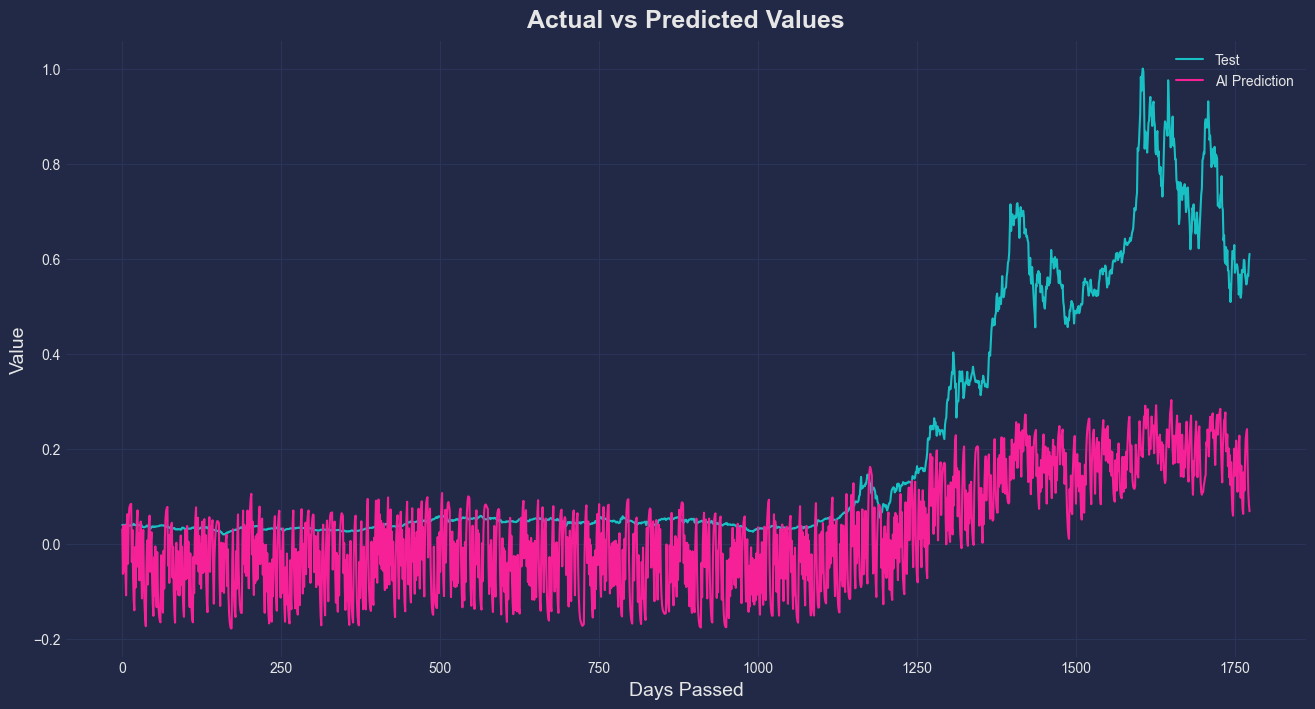

In [44]:
from keras.models import load_model

model.save('StockAIv2.h5')

plt.figure(figsize=(16,8))
plt.plot(y_test, label = 'Test')
plt.plot(y_pred, label = 'AI Prediction')

plt.legend()
title_font = {'fontweight': 'bold', 'fontsize': 18, 'verticalalignment': 'bottom'}
axis_label_font = {'fontsize': 14}

plt.title('Actual vs Predicted Values', fontdict=title_font)
plt.xlabel('Days Passed', fontdict=axis_label_font)
plt.ylabel('Value', fontdict=axis_label_font)



plt.show()
